In [1]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import os
import warnings
import time
import nfl_data_py as nfl
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, auc, classification_report, roc_curve, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
os.chdir("/Users/gmduncan/Desktop/NFL")

### Read in datasets and prepare them

In [75]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("test.csv")

# Sort dataframe and reset index to be able to evaluate model later
train_df = train_df.sort_values(by=['gameId','playId','nflId','frameId']).reset_index(drop=True)
val_df = val_df.sort_values(by=['gameId','playId','nflId','frameId']).reset_index(drop=True)

# Create eval df without extending dv to evaluate later
eval_df = val_df[val_df['tackle_binary_single'] == 1].copy()

In [55]:
# TODO: temporary until we fix dataset
train_df['tackle_efficiency_ingame'].fillna(0, inplace=True)
train_df['tackle_rating_ingame'].fillna(0, inplace=True)

val_df['tackle_efficiency_ingame'].fillna(0, inplace=True)
val_df['tackle_rating_ingame'].fillna(0, inplace=True)

# TODO: additional metrics we can include 
# Relative speed to ball carrier
train_df['relative_speed'] = train_df['s'] - train_df['bcs']

# Relative direction to ball carrier
train_df['relative_direction'] = train_df['unitDir'] - train_df['bcdir']
train_df['relative_direction'] = train_df['relative_direction'].apply(lambda x: (x + 360) % 360 if x < 0 else x % 360)

# Relative angle to ball carrier
x_diff = train_df['x'] - train_df['bcx']
y_diff = train_df['y'] - train_df['bcy']
train_df['relative_angle'] = np.arctan2(y_diff, x_diff) * (180/np.pi) 

# Relative speed to ball carrier
val_df['relative_speed'] = val_df['s'] - val_df['bcs']

# Relative direction to ball carrier
val_df['relative_direction'] = val_df['unitDir'] - val_df['bcdir']
val_df['relative_direction'] = val_df['relative_direction'].apply(lambda x: (x + 360) % 360 if x < 0 else x % 360)

# Relative angle to ball carrier
x_diff = val_df['x'] - val_df['bcx']
y_diff = val_df['y'] - val_df['bcy']
val_df['relative_angle'] = np.arctan2(y_diff, x_diff) * (180/np.pi) 

### Extend the dependent variable to other frames

In [56]:
frames_to_extend = 5
extend_dv = 'tackle_binary_single'

# Identify rows where tackle_binary_single is equal to 1
tackle_rows_train = train_df[train_df[extend_dv] == 1]

# Create a list to store the indices of rows to be updated
rows_to_update_train = []

# Get identifiers for each row with tackle_binary_single = 1 
for _, row in tackle_rows_train.iterrows():
    gamePlayId = row['gamePlayId']
    nflId = row['nflId']
    frameId = row['frameId']

    # Identify the rows to be updated based on gamePlayId, nflId, and frame
    rows_to_update_train.extend(
        train_df[
            (train_df['gamePlayId'] == gamePlayId) &
            (train_df['nflId'] == nflId) &
            (train_df['frameId'] > frameId - frames_to_extend) 
        ].index
    )
    
# Update the values in the identified rows
train_df.loc[rows_to_update_train, extend_dv] = 1

# Identify rows where tackle_binary_single is equal to 1
tackle_rows_val = val_df[val_df[extend_dv] == 1]

# Create a list to store the indices of rows to be updated
rows_to_update_val = []

# Get identifiers for each row with tackle_binary_single = 1 
for _, row in tackle_rows_val.iterrows():
    gamePlayId = row['gamePlayId']
    nflId = row['nflId']
    frameId = row['frameId']

    # Identify the rows to be updated based on gamePlayId, nflId, and frame
    rows_to_update_val.extend(
        val_df[
            (val_df['gamePlayId'] == gamePlayId) &
            (val_df['nflId'] == nflId) &
            (val_df['frameId'] > frameId - frames_to_extend) 
        ].index
    )
    
# Update the values in the identified rows
val_df.loc[rows_to_update_val, 'tackle_binary_single'] = 1

### Identify which columns to keep and drop, update dataframes

In [57]:
used_dv = ['tackle_binary_single']
all_dv = ['tackle_binary_all','tackle_nonbinary_all','tackle_nonbinary_single', 'tackle_binary_single']
cols_to_drop = ['gameId', 'playId', 'frameId', 'nflId'] + all_dv 

x_train = train_df.drop(columns = cols_to_drop)
x_val = val_df.drop(columns = cols_to_drop)

y_train = train_df[used_dv]
y_val = val_df[used_dv]

### Convert object variables to category variables

### Drop columns SMOTE can't process

### Prepare datasets to pass into model

In [59]:
# Drop columns SMOTE can't handle
x_train = x_train.drop(columns=['bcPosition','play_type','offenseFormation','surface','inside_outside','position','gamePlayId'])
x_val = x_val.drop(columns=['bcPosition','play_type','offenseFormation','surface','inside_outside','position','gamePlayId'])

# Apply SMOTE
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

dtrain = xgb.DMatrix(x_train_smote, label=y_train_smote, enable_categorical=True)
dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True)

### Create XGBoost model

In [60]:
# Set hyperparameters for XGBoost model
params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss', 
    'max_depth': 4,  
    'eta': 0.05,  
    'subsample': 0.9,  
    'colsample_bytree': 0.9,  
    'n_estimators': 140,
    'gamma': 0.2,
    'min_child_weight': 5,
    'scale_pos_weight': 5
}

# Train the XGBoost model with early stopping
num_rounds = 1000  
early_stopping_rounds = 10  

# Specify the validation set for early stopping
evals = [(dtrain, 'train'), (dval, 'validation')]

# Define the model
model = xgb.train(params, dtrain, num_rounds, evals=evals, early_stopping_rounds=early_stopping_rounds)

[0]	train-logloss:0.82866	validation-logloss:1.40900
[1]	train-logloss:0.77615	validation-logloss:1.31521
[2]	train-logloss:0.72685	validation-logloss:1.22767
[3]	train-logloss:0.68965	validation-logloss:1.16291
[4]	train-logloss:0.65267	validation-logloss:1.09867
[5]	train-logloss:0.62040	validation-logloss:1.04306
[6]	train-logloss:0.59182	validation-logloss:0.99421
[7]	train-logloss:0.56631	validation-logloss:0.95112
[8]	train-logloss:0.54337	validation-logloss:0.91262
[9]	train-logloss:0.52261	validation-logloss:0.87790
[10]	train-logloss:0.50622	validation-logloss:0.85121
[11]	train-logloss:0.48884	validation-logloss:0.82259
[12]	train-logloss:0.47307	validation-logloss:0.79668
[13]	train-logloss:0.45851	validation-logloss:0.77300
[14]	train-logloss:0.44512	validation-logloss:0.75137
[15]	train-logloss:0.43279	validation-logloss:0.73157
[16]	train-logloss:0.42143	validation-logloss:0.71343
[17]	train-logloss:0.41241	validation-logloss:0.69945
[18]	train-logloss:0.40252	validation-

### Model evaluation

In [61]:
# Evaluate the model
predictions = model.predict(dval)
binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

# Evaluate metrics
accuracy = accuracy_score(y_val, binary_predictions)
precision = precision_score(y_val, binary_predictions)
recall = recall_score(y_val, binary_predictions)
f1 = f1_score(y_val, binary_predictions)
roc_auc = roc_auc_score(y_val, binary_predictions)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}\n')

print(classification_report(y_val, binary_predictions))

Accuracy: 0.8930, Precision: 0.1580, Recall: 0.9703, F1-Score: 0.2718, ROC AUC: 0.9308
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    545260
           1       0.16      0.97      0.27     11461

    accuracy                           0.89    556721
   macro avg       0.58      0.93      0.61    556721
weighted avg       0.98      0.89      0.93    556721


### Visualize performance

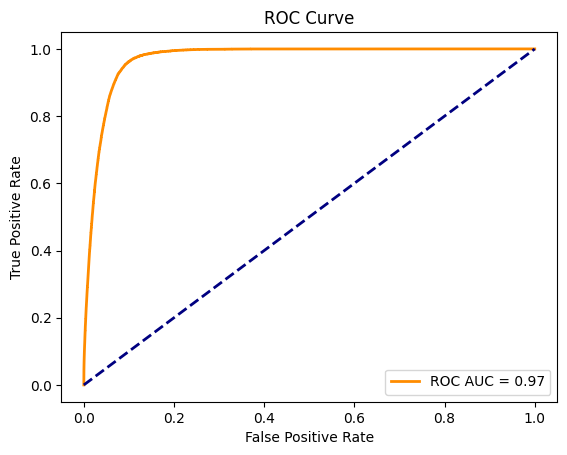

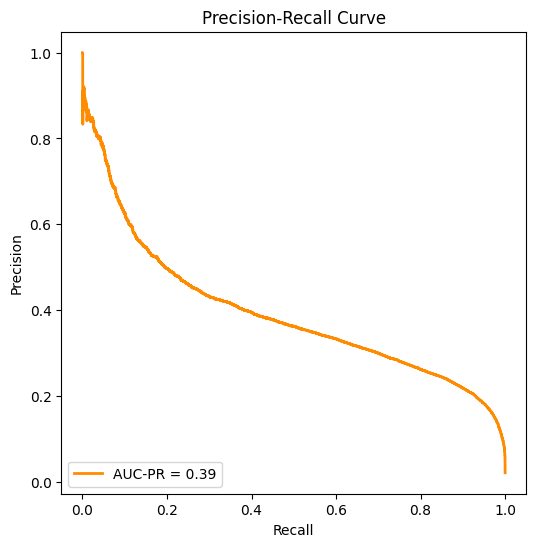

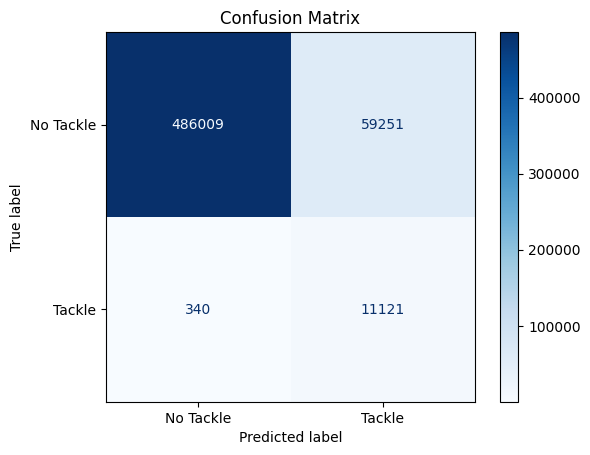

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

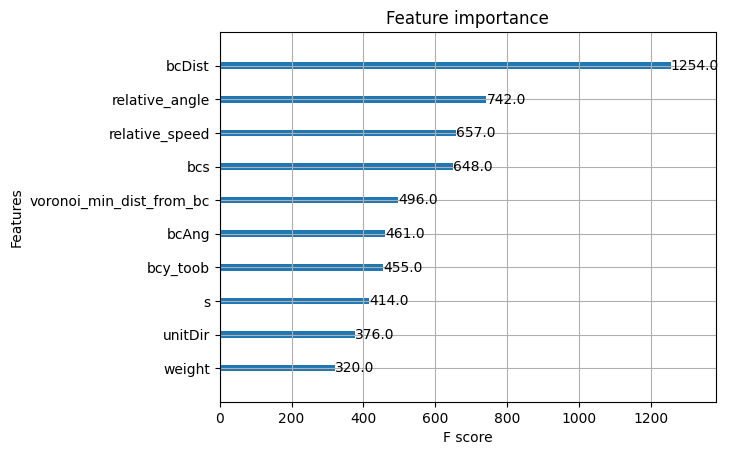

In [62]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_val, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val, predictions)
area_under_pr_curve = auc(recall, precision)

# Plotting the Precision-Recall Curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC-PR = {area_under_pr_curve:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_val, binary_predictions) 

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tackle', 'Tackle'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importance
xgb.plot_importance(model, max_num_features=10, importance_type='weight')

### Plot distribution of probabilities

(array([ 3140.,  3137.,  3194.,  3407.,  3702.,  4140.,  4922.,  6771.,
        11048., 26911.]),
 array([0.50001329, 0.54998261, 0.59995192, 0.6499213 , 0.69989061,
        0.74985993, 0.79982924, 0.84979856, 0.89976794, 0.94973725,
        0.99970657]),
 <BarContainer object of 10 artists>)

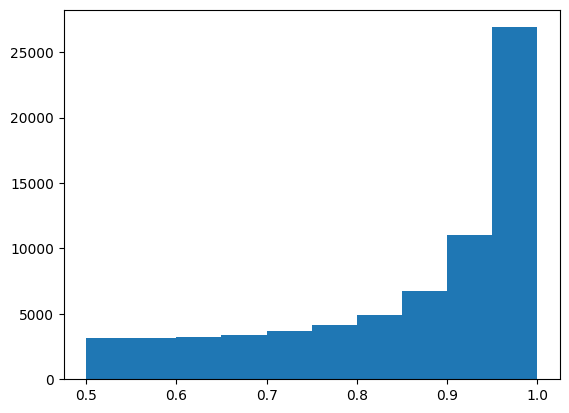

In [63]:
plt.hist(predictions[predictions > .5])

### Evaluate ability to identify a tackle in extended tackle frames

In [64]:
# Make binary predictions into a dataframe
binary_predictions_eval = pd.DataFrame(binary_predictions).rename(columns={0 : 'prediction'})

# Merge true labels output to predictions dataframe
binary_predictions_eval = binary_predictions_eval.merge(y_val, left_index = True, right_index = True, how = 'inner')

# Evaluate times it predicted tackle in any of the frames where tackle was extended
num_correct_tackle = 0

# Loop over eval_df 
for idx, row in eval_df.iterrows():
    # If tackle = 1, see if predicted a tackle on any of frames we extended tackle to for training
    if row['tackle_binary_single'] == 1:
        # Check if any of the previous 'frames_to_extend' frames have a prediction of 1
        if any(binary_predictions_eval.loc[idx - i, 'prediction'] == 1 for i in range(0, frames_to_extend)):
            num_correct_tackle += 1

### Display results of being able to identify a tackle

In [65]:
num_true_tackle = eval_df.tackle_binary_single.sum()

perc_true_tackle = num_correct_tackle / num_true_tackle
perc_missed_tackle = 1 - perc_true_tackle

print("Percentage of true tackles : ", perc_true_tackle, '\nPercentage of missed tackles: ', perc_missed_tackle)

Percentage of true tackles :  0.9878682842287695 
Percentage of missed tackles:  0.012131715771230511


### Merge all information together

In [66]:
# Merge probabilities back to original 
val_df_final = val_df.merge(pd.DataFrame(predictions), left_index=True, right_index=True, how='inner').rename(columns={0 : 'prediction'})
val_df_final = val_df_final[['gamePlayId','gameId','playId','nflId','frameId','tackle_binary_single','prediction']]

val_df_final

,gamePlayId,gameId,playId,nflId,frameId,tackle_binary_single,prediction
0,2022090800.0529.0,2.022091e+09,529.0,38577.0,19.0,0,0.003838
1,2022090800.0529.0,2.022091e+09,529.0,38577.0,20.0,0,0.003388
2,2022090800.0529.0,2.022091e+09,529.0,38577.0,21.0,0,0.001570
3,2022090800.0529.0,2.022091e+09,529.0,38577.0,22.0,0,0.004507
4,2022090800.0529.0,2.022091e+09,529.0,38577.0,23.0,0,0.005843
...,...,...,...,...,...,...,...
556716,2022110700.03707.0,2.022111e+09,3707.0,53505.0,50.0,0,0.004556
556717,2022110700.03707.0,2.022111e+09,3707.0,53505.0,51.0,0,0.004612
556718,2022110700.03707.0,2.022111e+09,3707.0,53505.0,52.0,0,0.005724
556719,2022110700.03707.0,2.022111e+09,3707.0,53505.0,53.0,0,0.004554


### Additional histograms to see how probabilities are distributed in different instances

(array([  77.,   60.,   53.,   70.,   85.,  120.,  191.,  350.,  947.,
        9508.]),
 array([0.00482166, 0.10431015, 0.20379864, 0.30328712, 0.40277562,
        0.50226414, 0.60175258, 0.70124108, 0.80072957, 0.90021807,
        0.99970657]),
 <BarContainer object of 10 artists>)

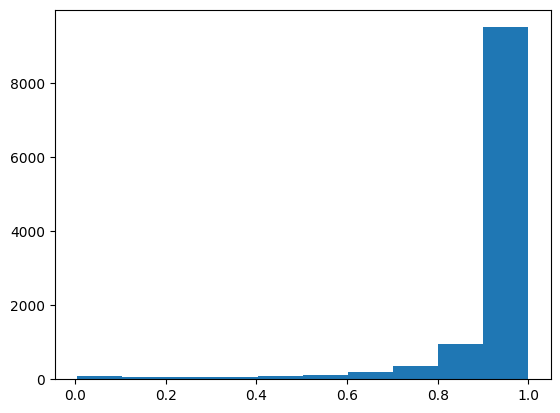

In [67]:
probs_for_tackles = val_df_final[val_df_final['tackle_binary_single'] == 1]
plt.hist(probs_for_tackles.prediction, bins = 10)

(array([442227.,  18518.,  10789.,   7850.,   6614.,   6154.,   6407.,
          7486.,  10741.,  28474.]),
 array([2.49662520e-07, 9.99526009e-02, 1.99904948e-01, 2.99857289e-01,
        3.99809659e-01, 4.99761999e-01, 5.99714339e-01, 6.99666679e-01,
        7.99619079e-01, 8.99571419e-01, 9.99523759e-01]),
 <BarContainer object of 10 artists>)

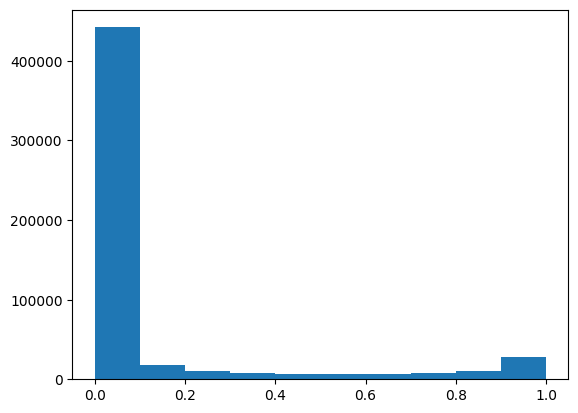

In [68]:
probs_no_tackles = val_df_final[val_df_final['tackle_binary_single'] == 0]
plt.hist(probs_no_tackles.prediction, bins = 10)

(array([ 3140.,  3137.,  3194.,  3407.,  3702.,  4140.,  4922.,  6771.,
        11048., 26911.]),
 array([0.50001329, 0.54998261, 0.59995192, 0.6499213 , 0.69989061,
        0.74985993, 0.79982924, 0.84979856, 0.89976794, 0.94973725,
        0.99970657]),
 <BarContainer object of 10 artists>)

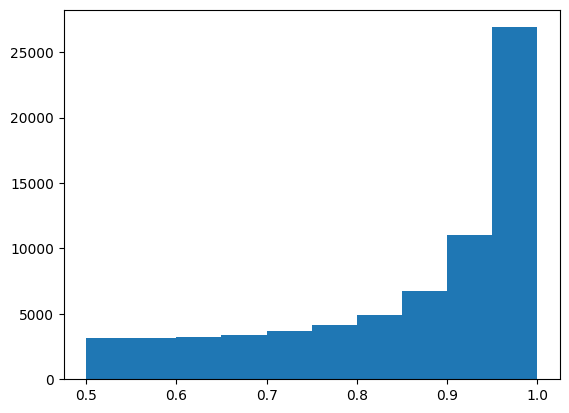

In [69]:
probs_over_50 = val_df_final[val_df_final['prediction'] >= 0.5]
plt.hist(probs_over_50.prediction, bins = 10)

(array([421858.,  20451.,  11028.,   7550.,   5934.,   4913.,   4220.,
          3703.,   3423.,   3269.]),
 array([2.49662520e-07, 4.99965250e-02, 9.99927968e-02, 1.49989069e-01,
        1.99985340e-01, 2.49981612e-01, 2.99977899e-01, 3.49974155e-01,
        3.99970442e-01, 4.49966699e-01, 4.99962986e-01]),
 <BarContainer object of 10 artists>)

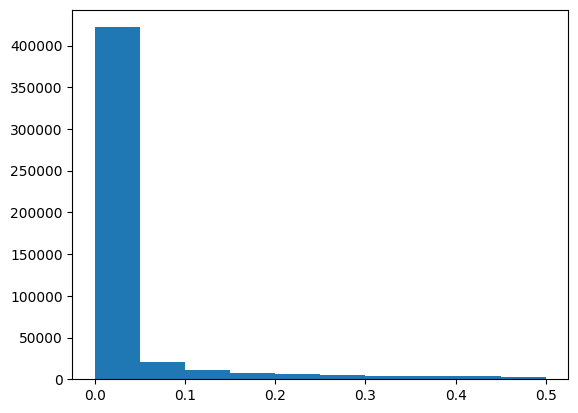

In [70]:
probs_under_50 = val_df_final[val_df_final['prediction'] < 0.5]
plt.hist(probs_under_50.prediction, bins = 10)

### Export results for write up

In [74]:
val_df_final.to_csv('model_results.csv', index=False)